# Libraries

In [130]:
import pandas as pd
import numpy as np
import tensorflow as tf

import keras
from keras import layers
from keras.layers import Conv1D, GRU, Dense, BatchNormalization, Dropout, MaxPool1D,Activation, regularizers
from keras import Sequential
from keras.preprocessing import text
from keras.layers import regularizers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras import callbacks
from keras.callbacks import Callback
from keras.models import load_model

import scipy.io.wavfile as wav

from sklearn.preprocessing import LabelEncoder

import shutil
import os
from pathlib import Path 
import re
from collections import OrderedDict

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction as aF


from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score, recall_score

import pickle

# Data Processing and Saving

In [4]:
path_data = Path('../data/')
os.listdir(path_data)

['wav',
 'spectogram',
 'Schuller_SpeechAnalysis.pdf',
 'time_series_pitch.csv',
 'X_devel_summary.csv',
 'readme.docx',
 'train_4-sec.csv',
 'devel_4-sec.csv',
 'X_train_summary.csv',
 'y_train.npy',
 'ComParE2018_AtypicalAffect.txt',
 'X_test_summary.csv',
 'test_4-sec.csv',
 'X_train_zero_np.npy']

In [8]:
df_labs = pd.read_csv(path_data/'ComParE2018_AtypicalAffect.txt', sep='\t')

def get_raw_data(file):
    [fs,x]  = audioBasicIO.readAudioFile(path_data/'wav'/file)
    [s,t] = aF.stFeatureExtraction(x,fs,0.050*fs,0.025*fs)
    s = s.T
    return s

def fetch_data(directory='wav/', subset='train'):
    sub = df_labs['file_name'].apply(lambda fn: subset in fn)
    df_lab_sub = df_labs[sub]
    y = df_lab_sub['emotion'].values
    fn = df_lab_sub['file_name']
    X = OrderedDict()
    for f in fn:
        X[f] = get_raw_data(f)
        
    return X.values(), y

#     x = np.resize(x,(fs*4,))
#     x = np.pad(x, fs*4, mode='constant')[:fs*4]

In [ ]:
(tr_X_raw, tr_y) = fetch_data(directory=path_data/'wav', subset='train')


In [13]:
(dv_X_raw, dv_y) = fetch_data(directory=path_data/'wav', subset='devel')


In [14]:
(test_X_raw, test_y) = fetch_data(directory=path_data/'wav', subset='test')


In [88]:
with open("tr_X_raw.pkl", "wb") as f:
    pickle.dump(list(tr_X_raw), f)
    
with open("dv_X_raw.pkl", "wb") as f:
    pickle.dump(list(dv_X_raw), f)
    
with open("test_X_raw.pkl", "wb") as f:
    pickle.dump(list(test_X_raw), f)
    
    
with open("tr_y.pkl", "wb") as f:
    pickle.dump(tr_y, f)
    
with open("dv_y.pkl", "wb") as f:
    pickle.dump(dv_y, f)
    
with open("test_y.pkl", "wb") as f:
    pickle.dump(test_y, f)

# Resume from here

In [89]:
with open("tr_X_raw.pkl", "rb") as f:
    tr_X_raw = pickle.load(f)
    
with open("dv_X_raw.pkl", "rb") as f:
    dv_X_raw = pickle.load(f)
    
with open("test_X_raw.pkl", "rb") as f:
    test_X_raw = pickle.load(f)
    
    
with open("tr_y.pkl", "rb") as f:
    tr_y = pickle.load(f)
    
with open("dv_y.pkl", "rb") as f:
    dv_y = pickle.load(f)
    
with open("test_y.pkl", "rb") as f:
    test_y = pickle.load(f)

In [53]:
def pad_data(X, pad_len=100, pad_zero=True):
    arr = []
    for x in X:
        if pad_zero:
            x = np.vstack([x, np.zeros((100, x.shape[1]))])[:100][np.newaxis, :, :]
        else:
            x = np.resize(x,(pad_len,x.shape[1]))[np.newaxis, :, :]
        arr.append(x)
    return np.vstack(arr)

In [55]:
tr_X_pad = pad_data(tr_X_raw)
dv_X_pad = pad_data(dv_X_raw)
test_X_pad = pad_data(test_X_raw)

In [64]:
m = np.mean(tr_X_pad.mean(axis=1),axis=0).reshape((1,34))
std = np.mean(tr_X_pad.std(axis=1),axis=0).reshape((1,34))

In [65]:
def normalize(mat):
    mat = (mat - m)/std
    return mat

In [70]:
tr_X = normalize(tr_X_pad)
dv_X = normalize(dv_X_pad)
test_X = normalize(test_X_pad)

In [90]:
le = LabelEncoder()
tr_y = le.fit_transform(tr_y)
dv_y = le.transform(dv_y)
test_y = le.transform(test_y)

In [91]:
from collections import Counter
c = Counter(tr_y)
len(tr_y)/np.asarray(list(c.values())) #class weights based on number of samples

array([ 1.46130302,  4.49798116, 17.87165775, 26.736     ])

In [136]:
class_weight = {0: 23.736,
                1: 4.49798116,
                2: 1.46130302,
                3: 17.87165775}

# same weights but add up to zero (so loss is easier to interpret)
class_weights_rescaled = {i:k/sum(class_weight.values()) for i,k in enumerate(class_weight.values())}
class_weights_rescaled

{0: 0.4990020177233622,
 1: 0.09456107492929176,
 2: 0.030720978913264353,
 3: 0.37571592843408175}

In [137]:
keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(filters=15, kernel_size=10, activation='relu', input_shape=tr_X.shape[1:]))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(layers.Flatten())
model.add(Dense(4, activation='sigmoid'))
# model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer=RMSprop(lr=.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 91, 15)            5115      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 45, 15)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 15)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39, 32)            3392      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 32)            5152      
__________

In [138]:
class UAR(Callback):
    def on_train_begin(self, logs={}):
        self.val_recalls = []
        self.max_recall = 0

    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(((self.model.predict(self.validation_data[0]))),
                                axis=1)
        val_targ = self.validation_data[1]
        _val_recall = recall_score(val_targ, val_predict, average="macro")
        self.val_recalls.append(_val_recall)
        print('UAR:'+str(_val_recall))
        if _val_recall > self.max_recall:
            self.max_recall = _val_recall
            self.model.save("1DCNNModel-v3.h5")
            print('UAR imporved. Saving model\n')
        return _val_recall

uar = UAR()

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                        patience=5, min_lr=.00001)

In [139]:
model.fit(tr_X, tr_y, 
          epochs=100,
          validation_data=(dv_X, dv_y),
          class_weight=class_weights_rescaled, 
          callbacks=[uar, reduce_lr])

Train on 3342 samples, validate on 3000 samples
Epoch 1/100
3342/3342 [==============================] - 1s 345us/step - loss: 0.1162 - acc: 0.1056 - val_loss: 1.4768 - val_acc: 0.0830
UAR:0.24932329144285664
UAR imporved. Saving model

Epoch 2/100
3342/3342 [==============================] - 1s 264us/step - loss: 0.1131 - acc: 0.1840 - val_loss: 1.4264 - val_acc: 0.1097
UAR:0.2769437687915949
UAR imporved. Saving model

Epoch 3/100
3342/3342 [==============================] - 1s 273us/step - loss: 0.1120 - acc: 0.2145 - val_loss: 1.3997 - val_acc: 0.1480
UAR:0.25640181074963686
Epoch 4/100
3342/3342 [==============================] - 1s 268us/step - loss: 0.1115 - acc: 0.2104 - val_loss: 1.3961 - val_acc: 0.1500
UAR:0.2670032262423567
Epoch 5/100
3342/3342 [==============================] - 1s 290us/step - loss: 0.1105 - acc: 0.2244 - val_loss: 1.4259 - val_acc: 0.1180
UAR:0.2839029931421236
UAR imporved. Saving model

Epoch 6/100
3342/3342 [==============================] - 1s 284us/

3342/3342 [==============================] - 1s 315us/step - loss: 0.1042 - acc: 0.3351 - val_loss: 1.4601 - val_acc: 0.2213
UAR:0.3548528795700256
Epoch 49/100
3342/3342 [==============================] - 1s 293us/step - loss: 0.1045 - acc: 0.3366 - val_loss: 1.4587 - val_acc: 0.2210
UAR:0.3547293617834643
Epoch 50/100
3342/3342 [==============================] - 1s 289us/step - loss: 0.1039 - acc: 0.3330 - val_loss: 1.4582 - val_acc: 0.2230
UAR:0.3556995600251564
UAR imporved. Saving model

Epoch 51/100
3342/3342 [==============================] - 1s 292us/step - loss: 0.1038 - acc: 0.3432 - val_loss: 1.4575 - val_acc: 0.2233
UAR:0.3558230778117176
UAR imporved. Saving model

Epoch 52/100
3342/3342 [==============================] - 1s 288us/step - loss: 0.1043 - acc: 0.3348 - val_loss: 1.4582 - val_acc: 0.2243
UAR:0.3566518142160504
UAR imporved. Saving model

Epoch 53/100
3342/3342 [==============================] - 1s 316us/step - loss: 0.1041 - acc: 0.3384 - val_loss: 1.4590 - va

3342/3342 [==============================] - 1s 297us/step - loss: 0.1023 - acc: 0.3627 - val_loss: 1.4534 - val_acc: 0.2470
UAR:0.3661521505296418
Epoch 98/100
3342/3342 [==============================] - 1s 318us/step - loss: 0.1019 - acc: 0.3519 - val_loss: 1.4506 - val_acc: 0.2483
UAR:0.36853593823951647
Epoch 99/100
3342/3342 [==============================] - 1s 308us/step - loss: 0.1023 - acc: 0.3591 - val_loss: 1.4528 - val_acc: 0.2487
UAR:0.3681727807889119
Epoch 100/100
3342/3342 [==============================] - 1s 286us/step - loss: 0.1022 - acc: 0.3564 - val_loss: 1.4516 - val_acc: 0.2500
UAR:0.36961171021697176


In [140]:
model_best = load_model('1DCNNModel-v3.h5')

In [141]:
y_pred = model_best.predict(dv_X)
y_pred = y_pred.argmax(axis = 1)

In [142]:
def reporting(y_test,y_pred):
    confusion_matrix = ConfusionMatrix(y_test, y_pred)
    confusion_matrix.plot()
    plt.show()
    print(confusion_matrix)
    print("\n",classification_report(y_test,y_pred))
    print(accuracy_score(y_test,y_pred))

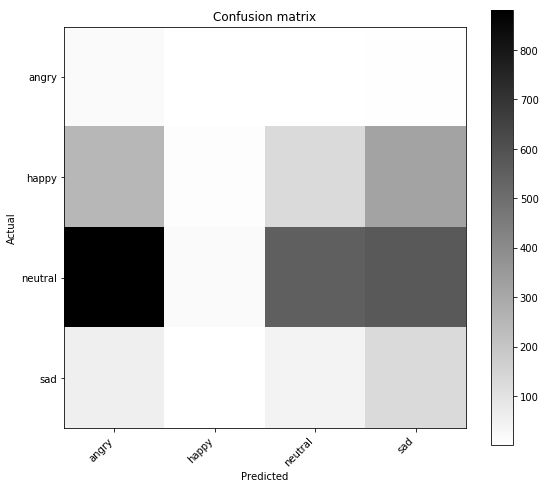

Predicted  angry  happy  neutral   sad  __all__
Actual                                         
angry         21      1        4     7       33
happy        250      9      131   319      709
neutral      881     19      554   570     2024
sad           58      1       44   131      234
__all__     1210     30      733  1027     3000

               precision    recall  f1-score   support

       angry       0.02      0.64      0.03        33
       happy       0.30      0.01      0.02       709
     neutral       0.76      0.27      0.40      2024
         sad       0.13      0.56      0.21       234

   micro avg       0.24      0.24      0.24      3000
   macro avg       0.30      0.37      0.17      3000
weighted avg       0.59      0.24      0.29      3000

0.23833333333333334


In [144]:
reporting(le.inverse_transform(dv_y), le.inverse_transform(y_pred)) #on validation set

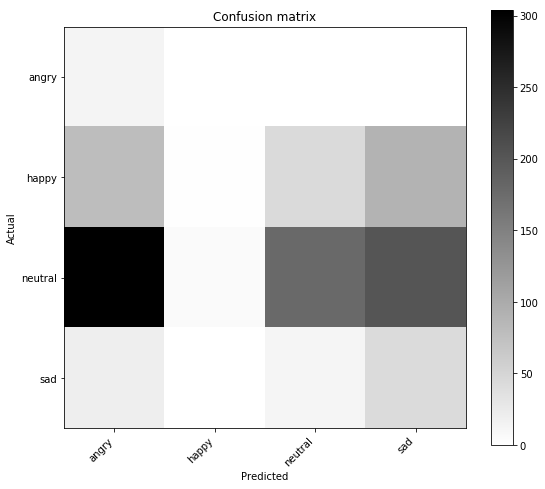

Predicted  angry  happy  neutral  sad  __all__
Actual                                        
angry         14      0        0    0       14
happy         79      2       45   91      217
neutral      304      6      178  203      691
sad           21      0       13   43       77
__all__      418      8      236  337      999

               precision    recall  f1-score   support

       angry       0.03      1.00      0.06        14
       happy       0.25      0.01      0.02       217
     neutral       0.75      0.26      0.38       691
         sad       0.13      0.56      0.21        77

   micro avg       0.24      0.24      0.24       999
   macro avg       0.29      0.46      0.17       999
weighted avg       0.59      0.24      0.29       999

0.23723723723723725


In [147]:
#test prediction 
y_pred_t = model_best.predict(test_X)
y_pred_t = y_pred_t.argmax(axis = 1)
reporting(le.inverse_transform(test_y), le.inverse_transform(y_pred_t))